# Activations, Gradients, BatchNorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
device = "cuda" if torch.cuda.is_available() else "cpu"
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# Build vocab of chars and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i for i, s in enumerate(chars, start=1)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f"{vocab_size = }")

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size = 27


In [4]:
# Build the dataset
import random

block_size = 3  # Context length


def build_dataset(words: list[str]) -> tuple[torch.tensor, torch.tensor]:
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)
    print(X.shape, y.shape)

    return X, y


random.seed(42)
shuffled_words = random.sample(words, len(words))
n1 = int(0.8 * len(shuffled_words))
n2 = int(0.9 * len(shuffled_words))

X_train, y_train = build_dataset(shuffled_words[:n1])  # 80%
X_val, y_val = build_dataset(shuffled_words[n1:n2])  # 10%
X_test, y_test = build_dataset(shuffled_words[n2:])  # 10%

torch.Size([182353, 3]) torch.Size([182353])
torch.Size([22884, 3]) torch.Size([22884])
torch.Size([22909, 3]) torch.Size([22909])


In [5]:
n_emb = 10  # Embedding dimension
n_hidden = 200  # Number of neurons in hidden layers of the MLP

g = torch.Generator(device=device).manual_seed(2147483647)  # Reprod
C = torch.randn((vocab_size, n_emb), generator=g, device=device)  # Embedding matrix
W1 = torch.randn(
    (n_emb * block_size, n_hidden), generator=g, device=device
)  # First weight matrix
b1 = torch.randn(n_hidden, generator=g, device=device)  # First bias
W2 = torch.randn(
    (n_hidden, vocab_size), generator=g, device=device
)  # Second weight matrix
b2 = torch.randn(vocab_size, generator=g, device=device)

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

11897

In [6]:
# Additional training hyperparameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=device)
    Xb, yb = X_train[ix], y_train[ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update step
    lr = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track statistics every 10,000 iters
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 26.3285
  10000/ 200000: 2.4478
  20000/ 200000: 2.5012
  30000/ 200000: 2.2516
  40000/ 200000: 2.5018
  50000/ 200000: 1.9498
  60000/ 200000: 2.2845
  70000/ 200000: 2.5794
  80000/ 200000: 2.3156
  90000/ 200000: 2.3952
 100000/ 200000: 1.7867
 110000/ 200000: 1.9023
 120000/ 200000: 2.2795
 130000/ 200000: 2.1548
 140000/ 200000: 2.3009
 150000/ 200000: 2.1544
 160000/ 200000: 1.9362
 170000/ 200000: 2.4731
 180000/ 200000: 1.8810
 190000/ 200000: 2.3111


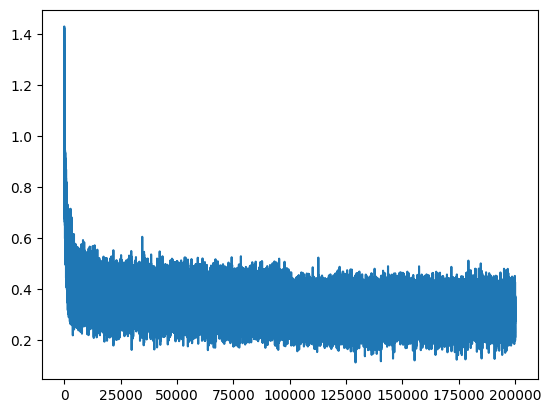

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad()
def split_loss(split: str):
    X, y = {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    }[split]
    emb = C[X]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.1085376739501953
val 2.150294542312622


In [9]:
g = torch.Generator(device=device).manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, n_emb)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # Decode and print generated words

khel.
ephyling.
rumaneli.
ana.
makisha.
macxonnan.
ran.
ramierlinn.
ermaleis.
nainy.
alee.
ose.
raylian.
dison.
ston.
thelett.
sani.
jamelyn.
avaugon.
sam.


## Calculating the Expected Initial Loss

At initialization, we have no reason to expect any of the 27 characters to be more likely than the others. The initial probability distribution is a uniform distribution assigning equal probability to all of the 27 characters.

In [10]:
-torch.tensor(1 / 27.0).log()  # Negative log-likelihood

tensor(3.2958)

If we scale up a tensor sample from a random Normal, then the loss can grow very high if the predicted class is wrong. We would like our initial logits to be roughly equal to not blow up the loss. According to Karpathy, with an unoptimized initialization the training loss will appear as a "hockey stick" where the loss drops very quickly during the first few iterations. During these iterations, the logits will be squashed down in an "easy" part of the training. However, we would like to focus on the hard gains of training the network with our iterations.

In [11]:
n_emb = 10  # Embedding dimension
n_hidden = 200  # Number of neurons in hidden layers of the MLP

g = torch.Generator(device=device).manual_seed(2147483647)  # Reprod
C = torch.randn((vocab_size, n_emb), generator=g, device=device)  # Embedding matrix
W1 = torch.randn(
    (n_emb * block_size, n_hidden), generator=g, device=device
)  # First weight matrix
b1 = torch.randn(n_hidden, generator=g, device=device)  # First bias
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.1
)  # Second weight matrix
b2 = torch.randn(vocab_size, generator=g, device=device) * 0.0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

11897

In [12]:
# Additional training hyperparameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=device)
    Xb, yb = X_train[ix], y_train[ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update step
    lr = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track statistics every 10,000 iters
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 4.0898
  10000/ 200000: 2.3876
  20000/ 200000: 2.2551
  30000/ 200000: 2.3932
  40000/ 200000: 2.4638
  50000/ 200000: 2.1045
  60000/ 200000: 2.1961
  70000/ 200000: 2.5197
  80000/ 200000: 2.3222
  90000/ 200000: 2.4651
 100000/ 200000: 1.9109
 110000/ 200000: 1.9026
 120000/ 200000: 2.2558
 130000/ 200000: 2.1241
 140000/ 200000: 2.2899
 150000/ 200000: 2.0210
 160000/ 200000: 1.8983
 170000/ 200000: 2.3711
 180000/ 200000: 1.8953
 190000/ 200000: 2.3014


## Fixing a Saturated Tanh

Another issue is in the `tanh` activation function. In the distribution of the activations, a majority of the values are either -1 or 1.

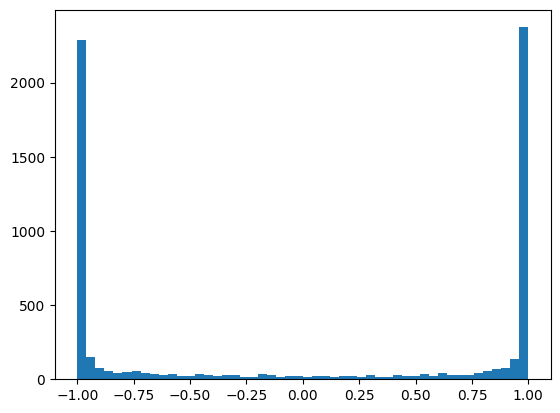

In [13]:
plt.hist(h.view(-1).tolist(), 50);

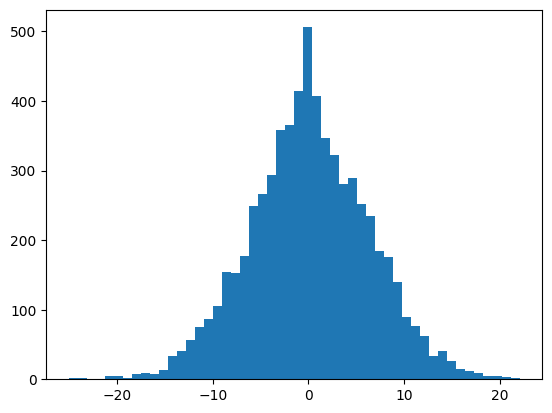

In [14]:
plt.hist(h_preact.view(-1).tolist(), 50);

The gradient accumulation for `tanh` is $\text{self.grad} = (1 - t^2) \cdot \text{out.grad}$ so when $t$ is close to -1 or 1 the gradient and thus the loss does not change much with any change in the input. If we plot the batch activations, if any of the neurons (columns) had all white activations (close to -1 or 1) then this would indicate that the neuron would never change the gradient and never learn. This can happen for other activation functions as well like sigmoid and ReLU.

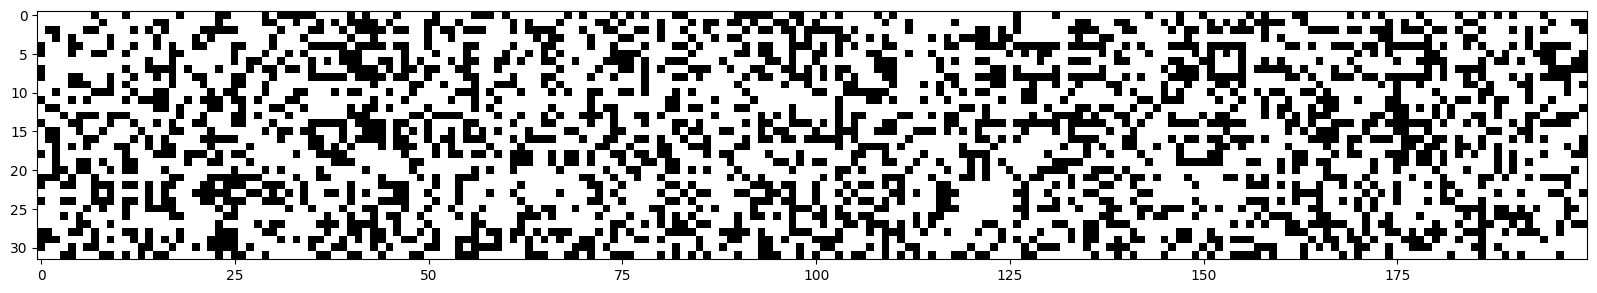

In [15]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs().cpu() > 0.99, cmap="gray", interpolation="nearest")

In [16]:
n_emb = 10  # Embedding dimension
n_hidden = 200  # Number of neurons in hidden layers of the MLP

g = torch.Generator(device=device).manual_seed(2147483647)  # Reprod
C = torch.randn((vocab_size, n_emb), generator=g, device=device)  # Embedding matrix
W1 = (
    torch.randn((n_emb * block_size, n_hidden), generator=g, device=device) * 0.1
)  # First weight matrix
b1 = torch.randn(n_hidden, generator=g, device=device) * 0.0  # First bias
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.1
)  # Second weight matrix
b2 = torch.randn(vocab_size, generator=g, device=device) * 0.0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

11897

In [17]:
# Additional training hyperparameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=device)
    Xb, yb = X_train[ix], y_train[ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update step
    lr = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track statistics every 10,000 iters
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.4774
  10000/ 200000: 2.2528
  20000/ 200000: 2.2227
  30000/ 200000: 2.3581
  40000/ 200000: 2.2712
  50000/ 200000: 2.0100
  60000/ 200000: 2.0713
  70000/ 200000: 2.3652
  80000/ 200000: 2.1966
  90000/ 200000: 2.5398
 100000/ 200000: 1.8599
 110000/ 200000: 1.9104
 120000/ 200000: 2.2162
 130000/ 200000: 2.1473
 140000/ 200000: 2.1651
 150000/ 200000: 2.0029
 160000/ 200000: 1.8647
 170000/ 200000: 2.3959
 180000/ 200000: 1.7955
 190000/ 200000: 2.1633


In [18]:
split_loss("train")
split_loss("val")

train 2.0471034049987793
val 2.108445167541504


# Kaiming Init

In this context, initialization optimization is easy since we only have a few layers. Throughout the network, we would like to preserve unit variance. To do this, we divide the weight matrix by standard deviation $\frac{1}{\sqrt{\text{feature\_in}}}$. Kaiming initialization takes on different formulas for different activation functions, but with modern neural network optimizations these initializations don't require as much tuning: $\text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}$

tensor(0.0174) tensor(1.0024)
tensor(0.0057) tensor(9.9863)
Post-normalization: tensor(0.0018) tensor(0.9986)


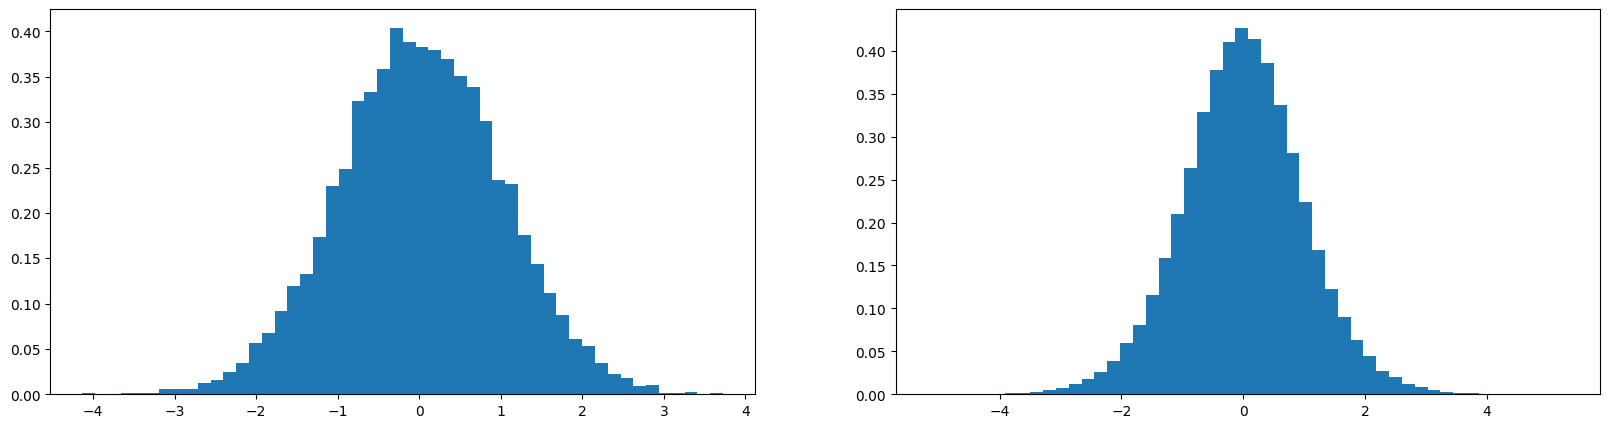

In [19]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.var())
print(y.mean(), y.var())
w /= 10 ** 0.5
y = x @ w
print("Post-normalization:", y.mean(), y.var())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [20]:
n_emb = 10  # Embedding dimension
n_hidden = 200  # Number of neurons in hidden layers of the MLP

g = torch.Generator(device=device).manual_seed(2147483647)  # Reprod
C = torch.randn((vocab_size, n_emb), generator=g, device=device)  # Embedding matrix
W1 = (
    torch.randn((n_emb * block_size, n_hidden), generator=g, device=device)
    * (5 / 3)  # 5/3 comes from gain for tanh
    / ((n_emb * block_size) ** 0.5)
)  # First weight matrix
b1 = torch.randn(n_hidden, generator=g, device=device) * 0.0  # First bias
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.1
)  # Second weight matrix
b2 = torch.randn(vocab_size, generator=g, device=device) * 0.0

params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

11897

In [21]:
# Additional training hyperparameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=device)
    Xb, yb = X_train[ix], y_train[ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yb)

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update step
    lr = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track statistics every 10,000 iters
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.8196
  10000/ 200000: 2.2635
  20000/ 200000: 2.2095
  30000/ 200000: 2.1662
  40000/ 200000: 2.4193
  50000/ 200000: 1.9692
  60000/ 200000: 2.2085
  70000/ 200000: 2.3124
  80000/ 200000: 2.2670
  90000/ 200000: 2.4311
 100000/ 200000: 1.8165
 110000/ 200000: 1.8409
 120000/ 200000: 2.1586
 130000/ 200000: 2.1239
 140000/ 200000: 2.1301
 150000/ 200000: 1.9460
 160000/ 200000: 1.8131
 170000/ 200000: 2.3609
 180000/ 200000: 1.8698
 190000/ 200000: 2.2332


In [22]:
split_loss("train")
split_loss("val")

train 2.0383667945861816
val 2.103935480117798


# Batch Normalization

We have hidden states prior to activations. The idea behind batch normalization is that we don't want these pre-activation states to be too small or too large (saturated `tanh`) and we would prefer them to be unit Gaussian (mean = 0, std = 1). To do this, we can normalize these hidden states to be unit Gaussian. These are differentiable operations and scale well to deep neural networks. In addition, we want these hidden states to be unit Gaussian only at initialization--we would like these distributions to be able to move around and allow backpropagation to tell us how they should move around. 

To do this, we introduce a scale and shift element.

In [23]:
h_preact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [24]:
n_emb = 10  # Embedding dimension
n_hidden = 200  # Number of neurons in hidden layers of the MLP

g = torch.Generator(device=device).manual_seed(2147483647)  # Reprod
C = torch.randn((vocab_size, n_emb), generator=g, device=device)  # Embedding matrix
W1 = (
    torch.randn((n_emb * block_size, n_hidden), generator=g, device=device)
    * (5 / 3)  # 5/3 comes from gain for tanh
    / ((n_emb * block_size) ** 0.5)
)  # First weight matrix
b1 = torch.randn(n_hidden, generator=g, device=device) * 0.0  # First bias
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.1
)  # Second weight matrix
b2 = torch.randn(vocab_size, generator=g, device=device) * 0.0

# Scale and shift elements in batch normalization
bn_gain = torch.ones((1, n_hidden), device=device)
bn_bias = torch.zeros((1, n_hidden), device=device)

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

12297

In [25]:
# Additional training hyperparameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=device)
    Xb, yb = X_train[ix], y_train[ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)  # Embed the characters into vectors
    h_preact = emb_cat @ W1 + b1  # Hidden layer pre-activation
    h_preact = (
        bn_gain
        * (h_preact - h_preact.mean(dim=0, keepdim=True))
        / h_preact.std(dim=0, keepdim=True)
        + bn_bias
    )  # Batch normalization
    h = torch.tanh(h_preact)  # Hidden layer
    logits = h @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, yb)  # Cross-entropy loss

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update step
    lr = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track statistics every 10,000 iters
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.5815
  10000/ 200000: 2.3536
  20000/ 200000: 2.3308
  30000/ 200000: 2.4221
  40000/ 200000: 2.4158
  50000/ 200000: 2.1007
  60000/ 200000: 2.1813
  70000/ 200000: 2.3760
  80000/ 200000: 2.2648
  90000/ 200000: 2.5007
 100000/ 200000: 1.7908
 110000/ 200000: 1.9824
 120000/ 200000: 2.1955
 130000/ 200000: 2.2417
 140000/ 200000: 2.3398
 150000/ 200000: 1.9827
 160000/ 200000: 1.8655
 170000/ 200000: 2.4505
 180000/ 200000: 1.8180
 190000/ 200000: 2.2989


In [28]:
@torch.no_grad()
def split_loss(split: str):
    x, y = {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h_preact = (
        bn_gain
        * (h_preact - h_preact.mean(dim=0, keepdim=True))
        / h_preact.std(dim=0, keepdim=True)
        + bn_bias
    )  # Include batch normalization in evaluation
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0707826614379883
val 2.111189126968384


Although batch normalization works well in practice, the examples are coupled together (hidden layer and logits are a function of all the other examples that came in the batch) and will create more noise in the output. As a side effect, batch normalization also acts as a regularization effect by "padding out any one example." 

This property is unfavorable and people are trying to move to other normalization techniques--layer normalization, instance normalization, group normalization, etc.

## Adjusting Batch Normalization Inference

Once we've trained a neural net, we would like to be able to deploy it and do inference. With batch normalization, we need to estimate the statistics for the mean and standard deviation of a batch. The batch normalization paper proposes two strategies: 

1.  A step at the end of training that calculates and sets the batch norm mean and standard deviation over the entire training set.
2.  Estimate the mean and standard deviation in a running manner **during** neural net training.

### End of Training Step

In [ ]:
with torch.no_grad():
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    bn_mean = hpreact.mean(0, keepdim=True)
    bn_std = hpreact.std(0, keepdim=True)

### During Training Step

In [45]:
n_emb = 10  # Embedding dimension
n_hidden = 200  # Number of neurons in hidden layers of the MLP

g = torch.Generator(device=device).manual_seed(2147483647)  # Reprod
C = torch.randn((vocab_size, n_emb), generator=g, device=device)  # Embedding matrix
W1 = (
    torch.randn((n_emb * block_size, n_hidden), generator=g, device=device)
    * (5 / 3)  # 5/3 comes from gain for tanh
    / ((n_emb * block_size) ** 0.5)
)  # First weight matrix
W2 = (
    torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.1
)  # Second weight matrix
b2 = torch.randn(vocab_size, generator=g, device=device) * 0.0

# Scale and shift elements in batch normalization
bn_gain = torch.ones((1, n_hidden), device=device)
bn_bias = torch.zeros((1, n_hidden), device=device)

# Running batch mean and std statistics
bn_mean_running = torch.zeros((1, n_hidden), device=device)
bn_std_running = torch.ones((1, n_hidden), device=device)

params = [
    C,
    W1,
    W2,
    b2,
    bn_gain,
    bn_bias,
]  # First bias (pre-act) is no longer needed since it is subtracted out in the batch norm calculation

for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

12097

In [46]:
# Additional training hyperparameters
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g, device=device)
    Xb, yb = X_train[ix], y_train[ix]

    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)  # Embed the characters into vectors
    h_preact = (
        emb_cat @ W1
    )  # Hidden layer pre-activation + with batch norm we do not need to include pre-act bias since it is subtracted out in the batch norm calculation
    bn_meani = h_preact.mean(0, keepdim=True)
    bn_stdi = h_preact.std(0, keepdim=True)
    h_preact = (
        bn_gain * (h_preact - bn_meani) / bn_stdi
        + bn_bias  # bn_bias now takes the role of the pre-act bias
    )  # Batch normalization
    h = torch.tanh(h_preact)  # Hidden layer
    logits = h @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, yb)  # Cross-entropy loss

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_meani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_stdi

    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update step
    lr = 0.1 if i < 100_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    # Track statistics every 10,000 iters
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.7918
  10000/ 200000: 2.0588
  20000/ 200000: 2.0372
  30000/ 200000: 2.1925
  40000/ 200000: 1.9210
  50000/ 200000: 1.9772
  60000/ 200000: 2.1037
  70000/ 200000: 2.1157
  80000/ 200000: 2.3081
  90000/ 200000: 2.3414
 100000/ 200000: 1.4944
 110000/ 200000: 2.1551
 120000/ 200000: 2.4237
 130000/ 200000: 2.1255
 140000/ 200000: 2.4727
 150000/ 200000: 2.1253
 160000/ 200000: 2.1445
 170000/ 200000: 1.9270
 180000/ 200000: 2.1062
 190000/ 200000: 2.5507


In [47]:
@torch.no_grad()
def split_loss(split: str):
    x, y = {
        "train": (X_train, y_train),
        "val": (X_val, y_val),
        "test": (X_test, y_test),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1 + b1
    h_preact = bn_gain * (h_preact - bn_mean_running) / bn_std_running + bn_bias
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.069911003112793
val 2.110374689102173


## Summary

-   Batch normalization is used to control the statistics of activations in the neural net and are applied prior to the activation.
-   It is common to sprinkle batch norm layers across the neural net, typically after layers with multiplication (e.g. linear or convolutional layers).
-   Batch norm internally has parameters for the gain and bias that are trained using backprop. It also has buffers--the running mean and std--that are trained with a running update to help record the overall mean and std across the training set. These buffers will be used to perform inference.

Related to convolutional neural nets (CNN):

-   The same pattern of linear output, batch norm, then activation also occurs in CNNs, but in the form of convolution, batch norm, then activation.
-   When initializing the convolutional layers, the bias is set to `False`. This is exactly for the same reason why we did not include bias in our calculations when we used batch norm. Batch norm's bias takes on the role of the pre-activation bias.